In this notebook, we see examples of training a neural network with PyTorch.
Unlike the direct function calls for various operations that we have in TensorFlow, we need to follow an object-oriented programming (Python-like) structure. We have to define a class (inheriting from an available NeuralNet class) for the network with defined layers and a forward pass function. We also need to instantiate other hyperparameters (gradient descent optimizer, scheduler). Then the learning model runs in a loop for the number of epochs stepping forward, computing losses, backpropagating and updating model parameters (not to be confused with hyperparameters), and evaluating accuracies for the test data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load data and process as done before for this dataset
df = pd.read_csv("./data/milling_failure.csv") # update path accordingly
df = df[df['Machine failure']!=0]
enc_failure = df.iloc[:,-5:]
data = df.iloc[:,3:-6]

indices_to_remove = enc_failure.index[enc_failure.apply(lambda row: (row == 0).sum(), axis=1) > 4]
enc_failure = enc_failure.drop(indices_to_remove)
data = data.drop(indices_to_remove)
indices_to_remove = enc_failure.index[enc_failure.apply(lambda row: (row == 1).sum(), axis=1) > 1]
enc_failure = enc_failure.drop(indices_to_remove)
data = data.drop(indices_to_remove)

df_cat = pd.from_dummies(enc_failure)

df = pd.concat([data, df_cat],axis=1)

df.rename(columns={'Air temperature [K]': 'air_temperature', 
                        'Process temperature [K]': 'process_temperature', 
                        'Rotational speed [rpm]':'rotational_speed', 
                        'Torque [Nm]': 'torque', 
                        'Tool wear [min]': 'tool_wear'
                        ,df.columns[-1]: 'Failure'}, inplace=True)

In [ ]:
df.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,Failure
50,298.9,309.1,2861,4.6,143,PWF
77,298.8,308.9,1455,41.3,208,TWF
160,298.4,308.2,1282,60.7,216,OSF
161,298.3,308.1,1412,52.3,218,OSF
168,298.4,308.3,1433,62.3,20,PWF


We use LabelEncoder for categorical data to convert categorical labels into a numerical format that machine learning algorithms can process. Many algorithms require numerical input, and LabelEncoder helps by assigning a unique integer to each category.

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1:]

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  

/Users/mdinar/code/megr_8090/venv/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


It is also very common to normalize the training data. We use the StandardScaler module.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

PyTorch requires all data be converted to its own matrix format called tensor.

### Defining a Neural Network Class

- **Class Definition**: Define a class for the neural network that inherits from `nn.Module`.
- **Initialization (`__init__` method)**:
  - **Fully Connected Layers**: Define the fully connected (fc) layers using `nn.Linear`.
  - **Batch Normalization**: Define batch normalization layers using `nn.BatchNorm1d`.
  - **Activation Functions**: Use activation functions like ReLU, defined using `nn.ReLU` or `nn.LeakyReLU`.
  - **Dropout Layers**: Define dropout layers using `nn.Dropout`.
  - **Output Layer**: Define the output layer using `nn.Linear`.
  - **Softmax**: For categorical data with cross-entropy loss, a separate softmax layer is not necessary because `nn.CrossEntropyLoss` combines `LogSoftmax` and `NLLLoss`.

- **Forward Function**:
  - **Structure**: The forward function should pass the input through the network layers in sequence.
  - **Nested Functions**: For each layer, apply the fully connected layer, followed by batch normalization, activation function, and dropout.
  - **Output Layer**: The final layer should be the output layer, without an activation function if using `nn.CrossEntropyLoss`.

### Example Structure of the Forward Function

- **Input**: Pass the input through the first fully connected layer.
- **Batch Normalization**: Apply batch normalization to the output of the fully connected layer.
- **Activation Function**: Apply the activation function (e.g., ReLU) to the normalized output.
- **Dropout**: Apply dropout to the activated output.
- **Repeat**: Repeat the above steps for each subsequent layer.
- **Output Layer**: Pass the final output through the output layer.

### Notes

- **Softmax**: Do not apply a softmax activation function to the output layer if using `nn.CrossEntropyLoss`, as it is included in the loss function.
- **Cross-Entropy Loss**: Use `nn.CrossEntropyLoss` for categorical data, which expects raw logits as input.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 4)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        # x = self.softmax(self.output(x))
        return x

In [ ]:
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # weight decay can be added here
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

from sklearn.metrics import accuracy_score

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/50], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(y_test_tensor, predicted)
    

Epoch [1/50], Loss: 4.2141
Epoch [2/50], Loss: 4.0309
Epoch [3/50], Loss: 3.9781
Epoch [4/50], Loss: 3.7294
Epoch [5/50], Loss: 3.5380
Epoch [6/50], Loss: 3.4623
Epoch [7/50], Loss: 3.3545
Epoch [8/50], Loss: 3.2293
Epoch [9/50], Loss: 3.1014
Epoch [10/50], Loss: 3.0972
Epoch [11/50], Loss: 2.9234
Epoch [12/50], Loss: 2.8192
Epoch [13/50], Loss: 2.7461
Epoch [14/50], Loss: 2.5816
Epoch [15/50], Loss: 2.5727
Epoch [16/50], Loss: 2.5673
Epoch [17/50], Loss: 2.5374
Epoch [18/50], Loss: 2.5612
Epoch [19/50], Loss: 2.4727
Epoch [20/50], Loss: 2.4822
Epoch [21/50], Loss: 2.3760
Epoch [22/50], Loss: 2.4022
Epoch [23/50], Loss: 2.4323
Epoch [24/50], Loss: 2.1630
Epoch [25/50], Loss: 2.2931
Epoch [26/50], Loss: 2.3031
Epoch [27/50], Loss: 2.2842
Epoch [28/50], Loss: 2.2369
Epoch [29/50], Loss: 2.2892
Epoch [30/50], Loss: 2.1235
Epoch [31/50], Loss: 2.1697
Epoch [32/50], Loss: 2.0261
Epoch [33/50], Loss: 2.1465
Epoch [34/50], Loss: 1.9581
Epoch [35/50], Loss: 2.1433
Epoch [36/50], Loss: 2.1206
E

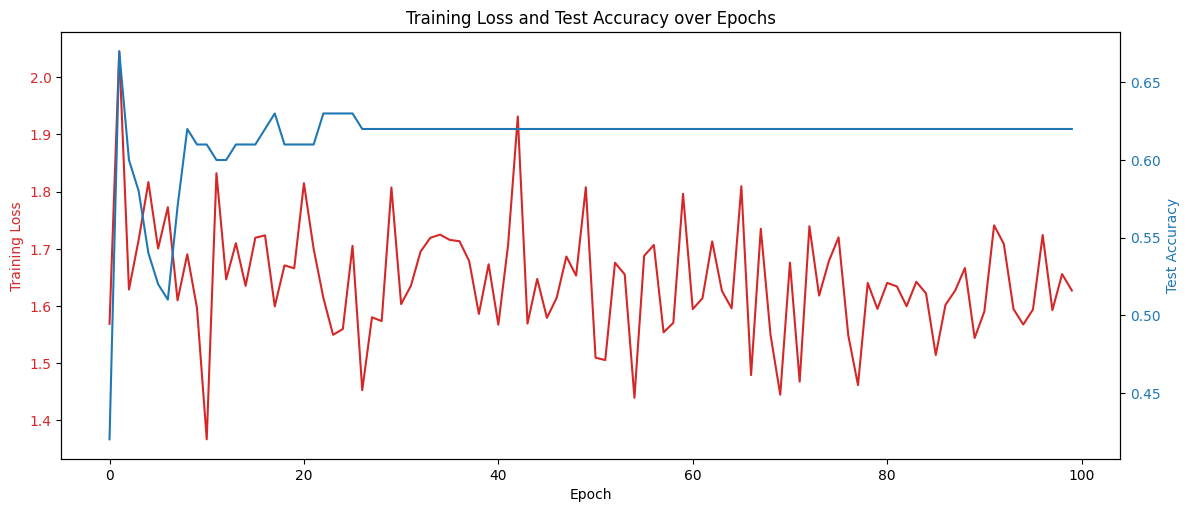

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(train_losses, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Test Accuracy', color=color)
ax2.plot(test_accuracies, color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Test Accuracy over Epochs')
plt.show()

If you were dealing with multi-label classification (where classes are not mutually exclusive), then you’d use multiple outputs with an independent sigmoid activation for each class. But for categorical classification, a single output with softmax is the recommended approach.

Additionally, if you're using a loss like PyTorch's nn.CrossEntropyLoss, you should not include an explicit softmax in your last layer for training. This loss function expects raw logits and internally applies the log-softmax operation for numerical stability.

However, if you need probabilities during inference, you can apply softmax to the logits at that time.

Below is another example with another dataset we have examined before. The objective here is to show an example of grid search, exploring different combinations of hyperparameters

In [ ]:
df = pd.read_csv('./data/ensemble_data.csv', sep='\t')
df.head()

,batches,force,thickness,life
0,4,188.17,1.28,normal
1,6,182.34,1.45,low
2,5,219.78,0.75,high
3,4,201.97,1.31,low
4,3,206.81,0.51,high


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import product

# Encode the categorical target variable
label_encoder = LabelEncoder()
df['life_encoded'] = label_encoder.fit_transform(df['life'])

# Split the data into features and target
X = df[['batches', 'force', 'thickness']].values
# Standardize the features
X = StandardScaler().fit_transform(X)
y = df['life_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the neural network architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(3, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 3)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        # x = self.softmax(self.output(x))
        return x

# Grid search for the best hyperparameters

lr = [0.0001, 0.001, 0.01]
weight_decay = [1e-5, 1e-4, 1e-3]
batch_size = [32, 64, 128]
gamma = [0.1, 0.5, 0.9]

# Instantiate the model, define the loss function and the optimizer
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
best_accuracy = 0
best_params = {}
num_epochs = 100

# Iterate over all combinations of hyperparameters
for lr_val, wd_val, gamma_val in product(lr, weight_decay, gamma):
    # Reinitialize the model, optimizer, and scheduler for each combination
    model = NeuralNet()
    optimizer = optim.Adam(model.parameters(), lr=lr_val, weight_decay=wd_val)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=gamma_val)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(y_test_tensor, predicted)
    
    # Update best parameters if current accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'lr': lr_val,
            'weight_decay': wd_val,
            'gamma': gamma_val
        }

print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Hyperparameters: {best_params}')


Best Accuracy: 0.6600
Best Hyperparameters: {'lr': 0.01, 'weight_decay': 0.001, 'gamma': 0.5}


Epoch [1/100], Loss: 1.5687, Accuracy: 0.4200
Epoch [2/100], Loss: 2.0454, Accuracy: 0.6700
Epoch [3/100], Loss: 1.6287, Accuracy: 0.6000
Epoch [4/100], Loss: 1.7159, Accuracy: 0.5800
Epoch [5/100], Loss: 1.8167, Accuracy: 0.5400
Epoch [6/100], Loss: 1.7004, Accuracy: 0.5200
Epoch [7/100], Loss: 1.7728, Accuracy: 0.5100
Epoch [8/100], Loss: 1.6098, Accuracy: 0.5700
Epoch [9/100], Loss: 1.6905, Accuracy: 0.6200
Epoch [10/100], Loss: 1.5962, Accuracy: 0.6100
Epoch [11/100], Loss: 1.3666, Accuracy: 0.6100
Epoch [12/100], Loss: 1.8323, Accuracy: 0.6000
Epoch [13/100], Loss: 1.6465, Accuracy: 0.6000
Epoch [14/100], Loss: 1.7098, Accuracy: 0.6100
Epoch [15/100], Loss: 1.6352, Accuracy: 0.6100
Epoch [16/100], Loss: 1.7193, Accuracy: 0.6100
Epoch [17/100], Loss: 1.7235, Accuracy: 0.6200
Epoch [18/100], Loss: 1.5991, Accuracy: 0.6300
Epoch [19/100], Loss: 1.6710, Accuracy: 0.6100
Epoch [20/100], Loss: 1.6659, Accuracy: 0.6100
Epoch [21/100], Loss: 1.8148, Accuracy: 0.6100
Epoch [22/100], Loss: 

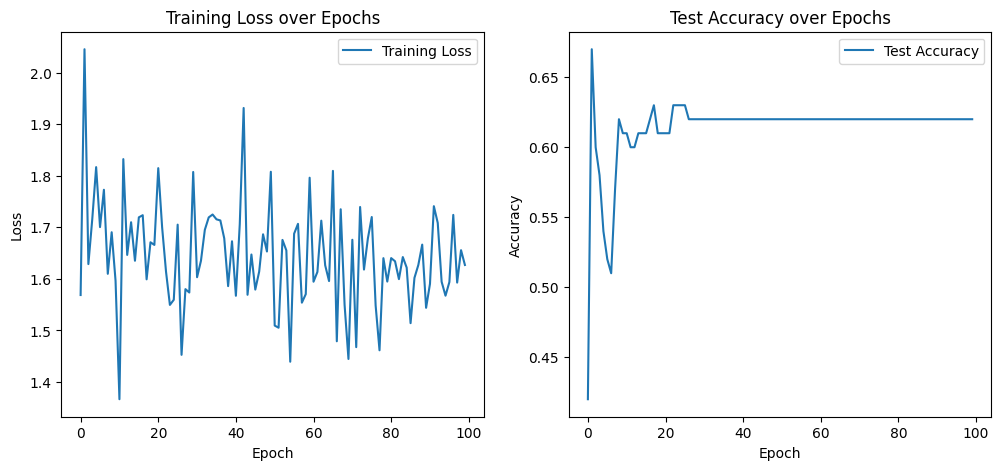

In [ ]:

optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=best_params['gamma'])

# Training the model
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(y_test_tensor, predicted)
        test_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.show()